# Instacart Market Basket Analysis
## Devin Maiello





This is the notebook I used for feature engineering, modelling, and optimizing F1 score

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import os
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

orders = pd.read_csv('./data/orders.csv')
priors = pd.read_csv('./data/order_products__prior.csv')
aisles = pd.read_csv('./data/aisles.csv')
departments = pd.read_csv('./data/departments.csv')
products = pd.read_csv('./data/products.csv')
train = pd.read_csv('./data/order_products__train.csv')

In [2]:
print('Orders: ', len(orders))
print('Priors: ', len(priors))
print('Train: ', len(train))

Orders:  3421083
Priors:  32434489
Train:  1384617


In [3]:
# Reduce the dataset to produce a smaller number of users
fracTrain = 0.1
fracTest = 1

# Total users in train set. This include both the actual training set and the holdout set
sampleOrdersTrain = orders[orders["eval_set"]=="train"][["user_id","order_id"]].drop_duplicates().sample(frac=fracTrain).reset_index(drop=True)
sampleOrdersTest = orders[orders["eval_set"]=="test"][["user_id","order_id"]].drop_duplicates().sample(frac=fracTest).reset_index(drop=True)
sampleOrders = pd.concat([sampleOrdersTrain, sampleOrdersTest], ignore_index=True)

orders = orders[orders["user_id"].isin(sampleOrders["user_id"])].reset_index(drop=True)
train = train[train["order_id"].isin(orders["order_id"])].reset_index(drop=True)
priors = priors[priors["order_id"].isin(orders["order_id"])].reset_index(drop=True)

In [4]:
#log = pd.merge(pd.concat([priors, train],ignore_index=1),orders, on='order_id', how='left')[['order_id', 'user_id', 'product_id', 'order_number']]
pr = priors.copy()
print(len(pr))
pr.head()



13827423


,order_id,product_id,add_to_cart_order,reordered
0,7,34050,1,0
1,7,46802,2,0
2,13,17330,1,0
3,13,27407,2,0
4,13,35419,3,0


In [5]:
print('Orders: ', len(orders))
print('Priors: ', len(priors))
print('Train: ', len(train))
print('Sample Train and Test: ', len(sampleOrders))
#print('Prior/Train: ', len(pr_tr))

Orders:  1456004
Priors:  13827423
Train:  137850
Sample Train and Test:  88121


prior    1367883
test       75000
train      13121
Name: eval_set, dtype: int64


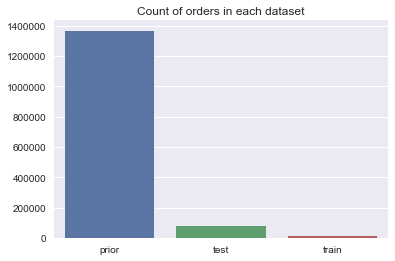

In [6]:
sizes = orders["eval_set"].value_counts()
print(sizes)
sns.barplot(x=sizes.index, y=sizes.values)
plt.title("Count of orders in each dataset")

### User Behavior Features

In [7]:
usr = orders.groupby('user_id')['days_since_prior_order'].mean().to_frame('avg_days_between_orders').reset_index()
dow = orders.groupby('user_id')['order_dow'].mean().to_frame('avg_order_dow').reset_index()
hod = orders.groupby('user_id')['order_hour_of_day'].mean().to_frame('avg_order_hod').reset_index()
hod['avg_order_hod'] = hod['avg_order_hod']/4
usr = usr.merge(dow, on='user_id')
usr = usr.merge(hod, on='user_id')
del dow
del hod
usr.head()

,user_id,avg_days_between_orders,avg_order_dow,avg_order_hod
0,3,12.000000,1.384615,4.076923
1,4,17.000000,4.500000,3.125000
2,6,13.333333,3.500000,4.250000
3,11,18.714286,4.500000,2.718750
4,12,26.000000,2.666667,2.791667


In [8]:
orders['Weekend?'] = [1 if x in [0,1] else 0 for x in orders['order_dow']]
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?
0,1374495,3,prior,1,1,14,NaN,1
1,444309,3,prior,2,3,19,9.0,0
2,3002854,3,prior,3,3,16,21.0,0
3,2037211,3,prior,4,2,18,20.0,0
4,2710558,3,prior,5,0,17,12.0,1


In [9]:
# build days_to_last_order
dsfo = orders.groupby('user_id')['days_since_prior_order'].cumsum().fillna(0)
orders['days_since_first_order'] = dsfo
max_days = orders.groupby('user_id')['days_since_first_order'].agg({'max_days':'max'}).reset_index()
orders = orders.merge(max_days, on = 'user_id', how = 'left')
orders['days_to_last_order'] = orders['max_days'] - orders['days_since_first_order']
orders['hod_group'] = (orders['order_hour_of_day'] / 4).astype('int')
orders.drop(['days_since_first_order', 'max_days'], axis=1, inplace=True)
del max_days
print(len(orders))
orders.head()

1456004


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,days_to_last_order,hod_group
0,1374495,3,prior,1,1,14,NaN,1,144.0,3
1,444309,3,prior,2,3,19,9.0,0,135.0,4
2,3002854,3,prior,3,3,16,21.0,0,114.0,4
3,2037211,3,prior,4,2,18,20.0,0,94.0,4
4,2710558,3,prior,5,0,17,12.0,1,82.0,4


In [10]:
# Create a merged table with user_id, product_id and times it has been ordered in all previous orders

t1 = priors[["order_id", "product_id"]]
t2 = orders[orders["eval_set"]=="prior"][["order_id","user_id"]]
df = pd.merge(t1, t2, on="order_id").drop("order_id", 1)
counts = pd.DataFrame({"Times_Ordered": df.groupby(by=["user_id","product_id"]).size()}).reset_index()

# Select only users in train set
# Do the same for the training set, showing all the single purchases
t1 = train[["order_id", "product_id"]]
t2 = orders[orders["eval_set"]=="train"][["order_id","user_id"]]
df = pd.merge(t1, t2, on="order_id").drop("order_id", 1)

# Aggregate data by orders.
# Find out which products have been repurchased
trainUsers = orders[orders["eval_set"]=="train"]["user_id"]
trainCounts = counts[counts["user_id"].isin(trainUsers)]

timesOrd_per_UsrXProd = pd.merge(trainCounts, df, on=["user_id","product_id"], how='left', indicator="Purchased")
timesOrd_per_UsrXProd["Repurchased"] = np.where(timesOrd_per_UsrXProd.Purchased == "both", 1, 0)
timesOrd_per_UsrXProd.drop("Purchased", 1, inplace=True)

print(timesOrd_per_UsrXProd.shape)

# Add columns with historical frequency (number of times product has been bought divided by number of orders from user)
ordersPerUser = orders[orders["eval_set"]=="train"][["user_id","order_number"]]
ordersPerUser["numberPriorOrders"] = ordersPerUser["order_number"]-1
ordersPerUser.drop("order_number", 1, inplace=True)

timesOrd_per_UsrXProd = pd.merge(timesOrd_per_UsrXProd, ordersPerUser, how="left", on="user_id")
timesOrd_per_UsrXProd["frequency"] = timesOrd_per_UsrXProd["Times_Ordered"]/timesOrd_per_UsrXProd["numberPriorOrders"]

del t1, t2, df, trainUsers, trainCounts


print(timesOrd_per_UsrXProd.shape)
timesOrd_per_UsrXProd.head()


(834419, 4)
(834419, 6)


,user_id,product_id,Times_Ordered,Repurchased,numberPriorOrders,frequency
0,23,2138,1,0,4,0.25
1,23,3108,1,0,4,0.25
2,23,3243,1,0,4,0.25
3,23,3518,1,0,4,0.25
4,23,3873,1,0,4,0.25


In [11]:
# The order number in the train/test sets corresponds to the total number of orders in the prior set
ordersPerUser = orders[orders["eval_set"].isin(["train","test"])][["user_id","order_number"]]
ordersPerUser.rename(columns={"order_number":"tot_orders"}, inplace=True)
ordersPerUser.head()

,user_id,tot_orders
12,3,13
18,4,6
22,6,4
30,11,8
36,12,6


In [12]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,7,34050,1,0
1,7,46802,2,0
2,13,17330,1,0
3,13,27407,2,0
4,13,35419,3,0


In [13]:
order_sizes = priors.groupby(['order_id']).size().to_frame('size_order').reset_index()
order_sizes['num_reordered'] = priors['reordered'].groupby(priors['order_id']).sum().reset_index()['reordered']
order_sizes.head()

,order_id,size_order,num_reordered
0,7,2,0
1,13,13,0
2,15,5,5
3,16,3,1
4,18,28,10


### Combine Priors With Order Data

In [14]:
priors = pd.merge(priors, orders, on='order_id')
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,days_to_last_order,hod_group
0,7,34050,1,0,142903,prior,11,2,14,30.0,0,24.0,3
1,7,46802,2,0,142903,prior,11,2,14,30.0,0,24.0,3
2,13,17330,1,0,45082,prior,2,6,17,1.0,0,82.0,4
3,13,27407,2,0,45082,prior,2,6,17,1.0,0,82.0,4
4,13,35419,3,0,45082,prior,2,6,17,1.0,0,82.0,4


In [15]:
len(priors)

13827423

### General Product Features

In [16]:
prior_sort = priors.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
prior_sort = prior_sort.assign(product_time = prior_sort.groupby(['user_id', 'product_id']).cumcount()+1)

sub1 = prior_sort[prior_sort['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prior_sort[prior_sort['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')

sub1['prod_orders'] = prior_sort.groupby('product_id')['product_id'].size()
sub1['prod_reorders'] = prior_sort.groupby('product_id')['reordered'].sum()
sub2 = sub2.reset_index().merge(sub1.reset_index())

# calculating reorder probability and ratio for the product
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_times'] = 1 + sub2['prod_reorders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_times', 'prod_reorder_ratio']]

del sub1, sub2, prior_sort

prd.head()

,product_id,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio
0,1,867,0.385580,2.717868,0.632065
1,2,36,0.058824,1.058824,0.055556
2,3,130,0.483871,4.193548,0.761538
3,4,137,0.384615,1.756410,0.430657
4,5,4,0.333333,1.333333,0.250000


In [17]:
products = pd.merge(products, prd, on='product_id')
products.head()

,product_id,product_name,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio
0,1,Chocolate Sandwich Cookies,61,19,867,0.385580,2.717868,0.632065
1,2,All-Seasons Salt,104,13,36,0.058824,1.058824,0.055556
2,3,Robust Golden Unsweetened Oolong Tea,94,7,130,0.483871,4.193548,0.761538
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,137,0.384615,1.756410,0.430657
4,5,Green Chile Anytime Sauce,5,13,4,0.333333,1.333333,0.250000


### Get Order Sizes and Create Cart Priority

Convert Add to Cart Order feature to a proportion of the total cart size

In [18]:
df = pd.merge(priors, order_sizes, on='order_id')
df['cart_priority'] = 1 - df['add_to_cart_order']/(df['size_order']+1)

del order_sizes

df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,days_to_last_order,hod_group,size_order,num_reordered,cart_priority
0,7,34050,1,0,142903,prior,11,2,14,30.0,0,24.0,3,2,0,0.666667
1,7,46802,2,0,142903,prior,11,2,14,30.0,0,24.0,3,2,0,0.333333
2,13,17330,1,0,45082,prior,2,6,17,1.0,0,82.0,4,13,0,0.928571
3,13,27407,2,0,45082,prior,2,6,17,1.0,0,82.0,4,13,0,0.857143
4,13,35419,3,0,45082,prior,2,6,17,1.0,0,82.0,4,13,0,0.785714


In [19]:
avg_sizes = df[['user_id','size_order','num_reordered']].groupby(['user_id']).mean().reset_index()
avg_sizes.rename(columns={"size_order":"avg_order_size", "num_reordered":"avg_n_reordered"}, inplace=True)
avg_sizes.head()

,user_id,avg_order_size,avg_n_reordered
0,3,7.886364,4.659091
1,4,4.555556,0.388889
2,6,5.285714,1.000000
3,11,13.808511,4.957447
4,12,17.918919,3.324324


In [20]:
timesOrdered = df.groupby(['user_id','product_id']).agg({'count','mean'})['cart_priority'].reset_index()
timesOrdered.rename(columns={"mean":"avg_cart_priority", "count":"times_ord"}, inplace=True)
timesOrdered = pd.merge(timesOrdered, avg_sizes, on='user_id')
df.drop(['cart_priority'], 1, inplace=True)

del avg_sizes

timesOrdered.head()

,user_id,product_id,avg_cart_priority,times_ord,avg_order_size,avg_n_reordered
0,3,248,0.700000,1,7.886364,4.659091
1,3,1005,0.285714,1,7.886364,4.659091
2,3,1819,0.692593,3,7.886364,4.659091
3,3,7503,0.142857,1,7.886364,4.659091
4,3,8021,0.500000,1,7.886364,4.659091


In [21]:
df = pd.merge(df, timesOrdered, on=["user_id","product_id"])
df = pd.merge(df, usr, on=['user_id'])
df = pd.merge(df, ordersPerUser, on=["user_id"])
df = pd.merge(df, products.drop('product_name',1), on="product_id")

del timesOrdered, usr, ordersPerUser

In [22]:
len(df.columns)

29

In [23]:
df["hist_freq"] = df["times_ord"]/df["tot_orders"]
df["log_freq"] = np.log(df["hist_freq"])
df = df.drop("hist_freq", 1)
df['hod_delta'] = df['avg_order_hod'] - df['hod_group']
df['dow_delta'] = df['avg_order_dow'] - df['order_dow']
df['orders_since_last'] = df['tot_orders'] - df['order_number']
df = df.drop('eval_set', 1)
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,...,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,log_freq,hod_delta,dow_delta,orders_since_last
0,7,34050,1,0,142903,11,2,14,30.0,0,...,31,7,7012,0.517653,3.640706,0.725328,-2.564949,0.711538,0.153846,2
1,1418511,34050,11,0,189157,6,4,14,24.0,0,...,31,7,7012,0.517653,3.640706,0.725328,-2.079442,0.312500,-1.875000,2
2,441427,34050,7,1,32953,38,2,14,14.0,0,...,31,7,7012,0.517653,3.640706,0.725328,-2.730029,0.967391,-0.608696,8
3,598458,34050,2,1,32953,39,2,20,7.0,0,...,31,7,7012,0.517653,3.640706,0.725328,-2.730029,-1.032609,-0.608696,7
4,698422,34050,21,0,32953,24,0,20,6.0,1,...,31,7,7012,0.517653,3.640706,0.725328,-2.730029,-1.032609,1.391304,22


In [24]:
print(len(df))
print(len(df.columns))

13793508
32


### Order Streaks Feature

Thanks Faron!

In [25]:
from joblib import Parallel, delayed
import multiprocessing

def apply_parallel(df_groups, _func):
    nthreads = multiprocessing.cpu_count() >> 1
    print("nthreads: {}".format(nthreads))

    res = Parallel(n_jobs=nthreads)(delayed(_func)(grp.copy()) for _, grp in df_groups)
    return pd.concat(res)


def add_order_streak(df):
    tmp = df.copy()
    tmp.user_id = 1

    UP = tmp.pivot(index="product_id", columns='order_number').fillna(-1)
    UP.columns = UP.columns.droplevel(0)

    x = np.abs(UP.diff(axis=1).fillna(2)).values[:, ::-1]
    df.set_index("product_id", inplace=True)
    df['order_streak'] = np.multiply(np.argmax(x, axis=1) + 1, UP.iloc[:, -1])
    df.reset_index(drop=False, inplace=True)
    return df

ordrs = orders.groupby(['user_id']).tail(100)
log = ordrs.merge(pr, how='inner', on='order_id')
log = log[['user_id', 'product_id', 'order_number']]
print('Log: ', len(log))
log = log.groupby('user_id')
print('Log: ', len(log))
%time streak = apply_parallel(log, add_order_streak)
print('Streaks: ', len(streak))

Log:  13827423
Log:  88121
nthreads: 2
CPU times: user 2min 43s, sys: 9.1 s, total: 2min 52s
Wall time: 6min 45s
Streaks:  13827423


In [26]:
pr_tr = pd.concat([pr, train])
len(pr_tr)

13965273

In [27]:
strk = streak.drop_duplicates().reset_index(drop=True)
#strk = strk[['user_id', 'product_id', 'order_streak']]
print(len(strk))
strk.head()

13827423


,product_id,user_id,order_number,order_streak
0,9387,3,1,-5.0
1,17668,3,1,-1.0
2,15143,3,1,-11.0
3,16797,3,1,-3.0
4,39190,3,1,8.0


### Get Only Last Time each Product Was Ordered for each User 

In [29]:
# In each [product_id, user_id] group, select only the row with max order number (last one)

%time lastProdOrders = df.groupby(["user_id","product_id"]).agg({'order_number':'max'}).reset_index()
lastProdOrders = lastProdOrders.merge(df, on=['user_id','product_id', 'order_number'], how='left')
print(len(lastProdOrders))
lastProdOrders.head()

CPU times: user 4.75 s, sys: 1.23 s, total: 5.98 s
Wall time: 6.2 s
5633796


,user_id,product_id,order_number,order_id,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,...,aisle_id,department_id,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,log_freq,hod_delta,dow_delta,orders_since_last
0,3,248,2,444309,3,0,3,19,9.0,0,...,117,19,2659,0.268337,1.625306,0.384731,-2.564949,0.076923,-1.615385,11
1,3,1005,10,676467,5,0,3,16,17.0,0,...,94,7,198,0.323810,1.885714,0.469697,-2.564949,0.076923,-1.615385,3
2,3,1819,7,1839752,2,1,0,15,7.0,1,...,88,13,993,0.338521,1.931907,0.482377,-1.466337,1.076923,1.384615,6
3,3,7503,3,3002854,6,0,3,16,21.0,0,...,117,19,5340,0.385256,2.224073,0.550375,-2.564949,0.076923,-1.615385,10
4,3,8021,2,444309,5,0,3,19,9.0,0,...,54,17,11739,0.430933,2.456886,0.592981,-2.564949,0.076923,-1.615385,11


### Combine Streaks and Last Product Orders

In [30]:
df = pd.merge(lastProdOrders, strk, how='left', on=['user_id','order_number', 'product_id'])
len(df)


5633796

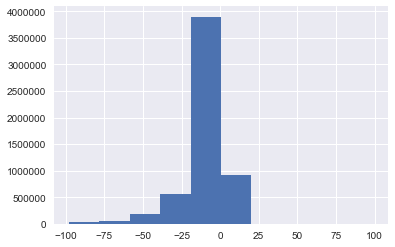

In [32]:
df['order_streak'] = df['order_streak'].fillna(-df['orders_since_last'])
df['order_streak'].hist()

### Put it All Together

In [33]:
#df = lastProdOrders
df.rename(columns={"order_id":"last_order_id"}, inplace=True)

del lastProdOrders, streak, strk

df.head()

,user_id,product_id,order_number,last_order_id,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,...,department_id,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,log_freq,hod_delta,dow_delta,orders_since_last,order_streak
0,3,248,2,444309,3,0,3,19,9.0,0,...,19,2659,0.268337,1.625306,0.384731,-2.564949,0.076923,-1.615385,11,-10.0
1,3,1005,10,676467,5,0,3,16,17.0,0,...,7,198,0.323810,1.885714,0.469697,-2.564949,0.076923,-1.615385,3,-2.0
2,3,1819,7,1839752,2,1,0,15,7.0,1,...,13,993,0.338521,1.931907,0.482377,-1.466337,1.076923,1.384615,6,-5.0
3,3,7503,3,3002854,6,0,3,16,21.0,0,...,19,5340,0.385256,2.224073,0.550375,-2.564949,0.076923,-1.615385,10,-9.0
4,3,8021,2,444309,5,0,3,19,9.0,0,...,17,11739,0.430933,2.456886,0.592981,-2.564949,0.076923,-1.615385,11,-10.0


In [34]:
print(list(df.columns))

['user_id', 'product_id', 'order_number', 'last_order_id', 'add_to_cart_order', 'reordered', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'Weekend?', 'days_to_last_order', 'hod_group', 'size_order', 'num_reordered', 'avg_cart_priority', 'times_ord', 'avg_order_size', 'avg_n_reordered', 'avg_days_between_orders', 'avg_order_dow', 'avg_order_hod', 'tot_orders', 'aisle_id', 'department_id', 'prod_orders', 'prod_reorder_probability', 'prod_reorder_times', 'prod_reorder_ratio', 'log_freq', 'hod_delta', 'dow_delta', 'orders_since_last', 'order_streak']


### Features for Train and Test Sets

In [36]:
features = df.drop(["last_order_id"], 1)
features["department_id"] = features["department_id"].astype(object)
features["aisle_id"] = features["aisle_id"].astype(object)

# Convert deparment_id and aisle_id to dummies
features = pd.get_dummies(features, drop_first=True)

featuresTrain = pd.merge(features, orders[orders["eval_set"]=="train"][["user_id"]],on="user_id",how="inner")

# Append target column
trainProducts = pd.merge(train, orders, on="order_id")[["user_id","product_id"]]
featuresTrain = pd.merge(featuresTrain, trainProducts, how="left", indicator="repurchased")
featuresTrain["repurchased"] = np.where(featuresTrain.repurchased == "both", 1, 0)

featuresTest = pd.merge(features, orders[orders["eval_set"]=="test"][["user_id"]],on="user_id",how="inner")

assert(featuresTrain.shape[0]+featuresTest.shape[0]==features.shape[0])
print(featuresTrain.columns)

Index(['user_id', 'product_id', 'order_number', 'add_to_cart_order',
       'reordered', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'Weekend?', 'days_to_last_order',
       ...
       'department_id_13', 'department_id_14', 'department_id_15',
       'department_id_16', 'department_id_17', 'department_id_18',
       'department_id_19', 'department_id_20', 'department_id_21',
       'repurchased'],
      dtype='object', length=184)


In [37]:
len(featuresTest)

4804390

In [38]:
featuresTrain.head()

,user_id,product_id,order_number,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,Weekend?,days_to_last_order,...,department_id_13,department_id_14,department_id_15,department_id_16,department_id_17,department_id_18,department_id_19,department_id_20,department_id_21,repurchased
0,23,2138,4,12,0,3,11,30.0,0,30.0,...,0,0,0,0,0,0,0,0,0,0
1,23,3108,2,6,0,0,10,9.0,1,65.0,...,0,0,0,1,0,0,0,0,0,0
2,23,3243,3,6,0,5,12,5.0,0,60.0,...,0,0,0,0,0,0,0,0,0,0
3,23,3518,1,4,0,5,14,NaN,0,74.0,...,0,0,0,0,1,0,0,0,0,0
4,23,3873,2,1,0,0,10,9.0,1,65.0,...,0,0,0,0,0,0,0,0,0,0


### Train, Test, Split

In [39]:
orders_train, orders_holdout = train_test_split(sampleOrdersTrain, test_size=0.25)
Xy_train = featuresTrain[featuresTrain["user_id"].isin(orders_train["user_id"])]
Xy_holdout = featuresTrain[featuresTrain["user_id"].isin(orders_holdout["user_id"])]

dropped = ["user_id","order_number","product_id","repurchased"]
y_train = Xy_train["repurchased"]
X_train = Xy_train.drop(dropped, 1)
y_holdout = Xy_holdout["repurchased"]
X_holdout = Xy_holdout.drop(dropped, 1)

### Train Logistic Regression Model on Train set and look at Coefficients

In [ ]:
lr = LogisticRegression()
lr.fit(X_train.values, y_train.values)

coeffs = (lr.coef_.ravel()*featuresTrain.drop(dropped,1).std()).sort_values()

sns.barplot(coeffs.values, coeffs.index)

In [ ]:
coeffs[:10]

In [ ]:
coeffs[-10:]

### Functions for computing F1 Score and converting results to correct cubmission format

In [40]:
# Dataframe with association between each user and its corresponding order in the training or test set
userToOrder = orders[orders["eval_set"].isin(["test","train"])][["user_id","order_id","eval_set"]]

# def dataFrameToSubmission(predictionsTest):
#     """ 
#     predictionsTest: dataframe with table of (product_id, order) to Series of the type (product_id, [orders])
#     """
#     # get all orders in the training set. We do this to add new rows with explicit "None" when an order_id is absent 
#     testOrders = userToOrder[userToOrder["eval_set"]=="test"][["order_id"]]
    
#     ret = []
#     for order_id, data in predictionsTest.groupby("order_id"):
#         products = data["product_id"].tolist()
#         productsStr = " ".join([str(p) for p in products])
#         ret.append({"order_id":order_id, "products":productsStr})
#     ret = pd.DataFrame(ret)
    
#     # We need to add explicit "None" for empty orders
#     ret = pd.merge(ret, testOrders, on="order_id", how="right")
#     ret[["products"]] = ret[["products"]].fillna("None")

#     return ret

# Compute F1 score on the holdout set
def computeF1(predictions_proba, y_true, thres):
    y_pred = (predictions_proba > thres).astype(int)
    
    return f1_score(y_pred, y_true)

### Tune probability threshold for optimal F1 Score

Kaggle is scoring on top F1 Score

In [ ]:
def plot_fl(model, feat):    
    thres = np.linspace(0.15,0.25,30)

    # The second column contains probabiity of positive
    proba_holdout = model.predict_proba(X_holdout[feat].values)[:,1]

    y = [computeF1(proba_holdout, y_holdout, t) for t in thres]
    plt.plot(thres, y)
    plt.ylabel("F1 score")
    plt.xlabel("threshold")
    
plot_fl(lr, X_holdout.columns)

In [ ]:
proba_holdout = lr.predict_proba(X_holdout[X_holdout.columns].values)[:,1]

In [41]:
from sklearn.metrics import confusion_matrix

def cnf_mtx(probs, threshold):
    labels = [0, 1]
    y_true = y_holdout.values
    y_pred = probs > threshold
    y_pred = y_pred.astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred, labels)
    sns.heatmap(cnf_matrix, annot=True, xticklabels = labels, yticklabels = labels, cmap = 'Blues', fmt='g', square = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
#cnf_mtx(proba_holdout, 0.21)

### Train Logistic Regression Model

In [ ]:
X = featuresTrain.drop(dropped, 1).values
y = featuresTrain["repurchased"].values
print(y)

model = LogisticRegression().fit(X, y)

In [ ]:
threshold = 0.21

def model_and_submit(model, threshold, feat):
    test_drop_col = ["user_id","last_order_number","product_id"]
    feat = [x for x in feat if x not in test_drop_col]
    predTest = model.predict_proba(featuresTest[feat].values)[:,1] > threshold
    purchasedTest = pd.concat([featuresTest[["user_id","product_id"]], pd.DataFrame({"Repurchased":predTest})], axis=1)
    purchasedTest = purchasedTest[purchasedTest["Repurchased"]==True].drop("Repurchased", 1).reset_index(drop=True)

    # Reappend order_id information
    purchasedTest = pd.merge(purchasedTest, orders[orders["eval_set"]=="test"], on="user_id")[["order_id","product_id"]]

    print(purchasedTest.head())

    submission = dataFrameToSubmission(purchasedTest)
    submission.to_csv("LR2sub.csv", columns=["order_id", "products"], index=False)
    sub = pd.read_csv('LR2sub.csv')
    print('None Order Total: ', len(sub[sub['products']=='None']))
        

In [ ]:
model_and_submit(model, threshold, list(featuresTest.columns))

In [ ]:
sub = pd.read_csv('sub.csv')
sub.head()

In [ ]:
len(sub[sub['products']=='None'])

### XGBoost

slow but great results

In [46]:
import xgboost as xgb

In [47]:
xgb_model = xgb.XGBClassifier(max_depth=6, n_estimators=2000, learning_rate=0.05, nthread=-1)

eval_set = [(X_holdout, y_holdout)]

xgb_model.fit(X_train, y_train, early_stopping_rounds=50, 
        eval_metric=["logloss"], eval_set=eval_set)

[0]	validation_0-logloss:0.658687
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.627511
[2]	validation_0-logloss:0.599214
[3]	validation_0-logloss:0.57343
[4]	validation_0-logloss:0.549849
[5]	validation_0-logloss:0.528274
[6]	validation_0-logloss:0.508441
[7]	validation_0-logloss:0.490179
[8]	validation_0-logloss:0.473359
[9]	validation_0-logloss:0.457845
[10]	validation_0-logloss:0.443467
[11]	validation_0-logloss:0.4302
[12]	validation_0-logloss:0.417893
[13]	validation_0-logloss:0.406495
[14]	validation_0-logloss:0.39591
[15]	validation_0-logloss:0.38606
[16]	validation_0-logloss:0.376897
[17]	validation_0-logloss:0.368388
[18]	validation_0-logloss:0.360458
[19]	validation_0-logloss:0.353072
[20]	validation_0-logloss:0.346197
[21]	validation_0-logloss:0.339766
[22]	validation_0-logloss:0.333761
[23]	validation_0-logloss:0.328175
[24]	validation_0-logloss:0.322966
[25]	validation_0-logloss:0.318092
[26]	validation_0-logloss:0.313565
[2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### XGB Feature Importances

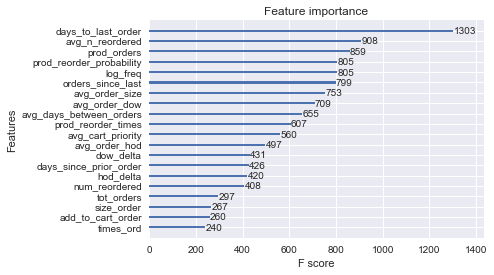

In [48]:
xgb.plot_importance(xgb_model, max_num_features=20)

In [43]:
X = featuresTrain.drop(dropped, 1)
y = featuresTrain["repurchased"]


#xgb_model2 = xgb.XGBClassifier(max_depth=6, n_estimators=929, learning_rate=0.05, nthread=-1)
#xgb_model2.fit(X, y, eval_metric=["logloss"])
print('done')

done


### Save Model

In [ ]:
import pickle
filename = 'xgb_model3.pkl'
#pickle.dump(xgb_model, open(filename, 'wb'))



In [ ]:
filename = 'xgb_model3.pkl'
xgb_model = pickle.load(open(filename, 'rb'))

### LightGBM

much faster than XGBoost but gives very similar results!

In [44]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train,y_train) 
lgb_eval = lgb.Dataset(X_holdout, y_holdout)

lgb_full = lgb.Dataset(X,y)

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'binary_logloss', 'auc'},
        'num_leaves': 256,
        'min_sum_hessian_in_leaf':20,
        'max_depth': -12,
        'learning_rate': 0.05,
        'feature_fraction': 0.6,
        # 'bagging_fraction': 0.9,
        # 'bagging_freq': 3,
        'verbose': 1
    }


lgbm = lgb.train(params,lgb_train,num_boost_round=2000,valid_sets=lgb_eval,early_stopping_rounds=50)


[1]	valid_0's auc: 0.810296	valid_0's binary_logloss: 0.65887
Train until valid scores didn't improve in 50 rounds.
[2]	valid_0's auc: 0.823293	valid_0's binary_logloss: 0.62762
[3]	valid_0's auc: 0.825811	valid_0's binary_logloss: 0.599148
[4]	valid_0's auc: 0.82555	valid_0's binary_logloss: 0.57373
[5]	valid_0's auc: 0.825945	valid_0's binary_logloss: 0.550217
[6]	valid_0's auc: 0.826394	valid_0's binary_logloss: 0.528725
[7]	valid_0's auc: 0.827036	valid_0's binary_logloss: 0.508818
[8]	valid_0's auc: 0.827681	valid_0's binary_logloss: 0.490407
[9]	valid_0's auc: 0.828039	valid_0's binary_logloss: 0.47346
[10]	valid_0's auc: 0.828175	valid_0's binary_logloss: 0.457824
[11]	valid_0's auc: 0.82785	valid_0's binary_logloss: 0.443747
[12]	valid_0's auc: 0.828131	valid_0's binary_logloss: 0.430408
[13]	valid_0's auc: 0.828272	valid_0's binary_logloss: 0.418
[14]	valid_0's auc: 0.828258	valid_0's binary_logloss: 0.406592
[15]	valid_0's auc: 0.82896	valid_0's binary_logloss: 0.396497
[16]	

### LGBM Feature Importances

We notice some different features are more important here than in XGBoost

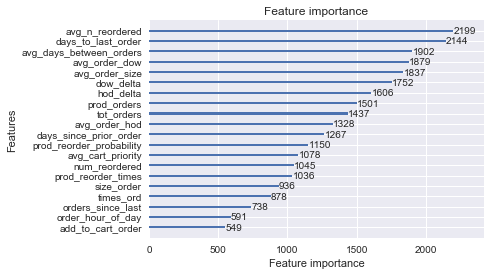

In [51]:
lgb.plot_importance(lgbm, max_num_features=20)

In [ ]:
filename = 'lgb_model.pkl'
pickle.dump(lgbm, open(filename, 'wb'))

In [ ]:
lgbm_full = lgb.train(params,lgb_full, 260)
print('lgb done')

In [ ]:
filename = 'lgb_model2.pkl'
pickle.dump(lgbm_full, open(filename, 'wb'))

### Code to Optimize Reorders for F1 on a User Level

Thank you 'Faron' from the Kaggle Discussion Boards, I learned a lot from this!

Read this paper on how to optimize F1 [Optimizing F-measure: A Tale of Two Approaches](https://arxiv.org/abs/1206.4625)

In [45]:
class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)

### Find optimal threshold for F1

Great strategy for the beginning of the competition, but Faron's F1 Optimizer proved to be way more effective than choosing a signle threshold.

I used Faron's optimizer for my final submission

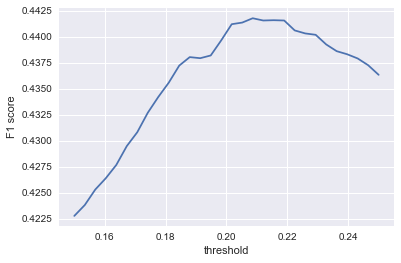

In [52]:
def xgb_plot_f1(model, feat):    
    thres = np.linspace(0.15,0.25,30)
    #d_holdout = xgb.DMatrix(X_holdout)
    # The second column contains probabiity of positive
    xgb_holdout = model.predict_proba(X_holdout)[:,1]
    #xgb_holdout = model.predict(d_holdout)
    y = [computeF1(xgb_holdout, y_holdout, t) for t in thres]
    plt.plot(thres, y)
    plt.ylabel("F1 score")
    plt.xlabel("threshold")
    
#xgb_plot_f1(bst, X_holdout.columns)
xgb_plot_f1(xgb_model, X_holdout.columns)

### Make Predictions and Submit

Here I allow the option to input two models (say an XGBoost model and LightGBM model) and then take the average of the two predicted probabilities (hopefully less overfitting for final leaderboard this way). 

This method placed me in the top 20% of the competition!

In [55]:
def gb_optimize(model1, model2, feat):
    test_drop_col = ["user_id","order_number","product_id", "Unnamed: 0"]
    feat = [x for x in feat if x not in test_drop_col]
    

    predTest1 = model1.predict(featuresTest[feat])
    predTest2 = model2.predict_proba(featuresTest[feat])[:,1]
    
    predTest = [(x+y)/2 for x,y in zip(predTest1,predTest2)]
    
    purchasedTest = pd.concat([featuresTest[["user_id","product_id"]], pd.DataFrame({"Repurchased":predTest})], axis=1)
    
    submit_dict = {}
    count=0
    
    ### Using Farons F1 Optimizer for each user in test set
    for user in list(purchasedTest['user_id'].unique()):
        if count%10000==0:
            print(count)
            
        user_df = purchasedTest[purchasedTest['user_id']==user].sort_values('Repurchased', ascending=False)
        P = user_df['Repurchased']
        L = list(user_df['product_id'])
        pNone = (1.0 - P).prod()
        opt = F1Optimizer.maximize_expectation(P, pNone)
        best_prediction = ['None'] if opt[1] else []
        best_prediction += (L[:opt[0]])
        submit_dict[user] = ' '.join(str(x) for x in best_prediction)
        count+=1
    
    ### converting to correct submission format
    
    submit = pd.DataFrame.from_dict(submit_dict, orient='index')

    submit.reset_index(inplace=True)
    submit.columns = ['user_id', 'products']
    purchasedTest = pd.merge(submit, orders[orders["eval_set"]=="test"], on="user_id")[["order_id","products"]]
    purchasedTest.sort_values('order_id', ascending=True).to_csv('F1_opt_lgb.csv', index=False)
    f1_opt = pd.read_csv('F1_opt_lgb.csv')
    print('None Order Total: ', len(f1_opt[f1_opt['products']=='None']))
    
%time gb_optimize(lgbm, xgb_model, featuresTest.columns)

0
10000
20000
30000
40000
50000
60000
70000
None Order Total:  1468
CPU times: user 59min 47s, sys: 2min 46s, total: 1h 2min 34s
Wall time: 1h 8min 32s


### Evaluate Models

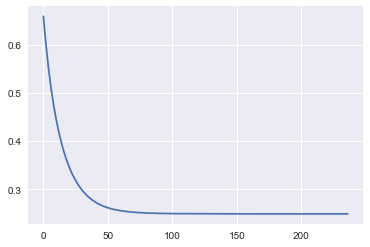

In [56]:
rounds = np.arange(len(xgb_model.evals_result()['validation_0']['logloss']))
logloss = xgb_model.evals_result()['validation_0']['logloss']
plt.plot(rounds,logloss)